# Abstractive versus Extractive

In [189]:
import torch, transformer_lens, itertools, torchvision
from measureLM import visualizing, decoding, patching, scoring
from functools import partial
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  

In [190]:
model = transformer_lens.HookedTransformer.from_pretrained("gpt2-medium").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  cpu


In [209]:
## encoding
token_candidates = ["Paris", "France", "Poland", "Warsaw"]
prompts = [("Q: What is the capital of France? A: Paris Q: What is the capital of Poland? A:",
            'Warsaw is the capital of Poland. Berlin is the capital of Germany. Q: What is the capital of Poland? A:'),
           ("Q: What is the relationship between Joe Biden and Donald Trump? A:",
            'Joe Biden and Donald Trump are enemies. Q: What is the relationship between Joe Biden and Donald Trump? A:'),
           ("Q: When was Barrack Obama born? A:",
            'Trump was born in 1946. Barrack Obama was born in 1961. Q: When was Barrack Obama born? A:')]

example = 0
i = 1
logits, activs, tokens = decoding.encode(prompts[example][i], model)
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(logits[:,-1,:], k=10).indices.tolist()[0])
print(pred, (len(tokens[0])))

['ĠWarsaw', 'ĠIt', 'ĠThe', 'ĠPoland', 'ĠQ', 'ĠBerlin', 'ĠIn', 'ĠPrague', 'ĠW', 'ĠPolish'] 26


In [210]:
def token_select(layer_token_vec, tok_type="last"):
    if tok_type == "last":
        layer_token_vec = layer_token_vec[...,-1].squeeze().detach()
    if tok_type == "mean":
        layer_token_vec = layer_token_vec.mean(-1).squeeze().detach()
    return layer_token_vec


def layer_norm(layer_token_vec):

    mean = torch.mean(layer_token_vec, dim=-1).unsqueeze(-1).repeat(1,1,layer_token_vec.shape[-1])
    std = torch.std(layer_token_vec, dim=-1).unsqueeze(-1).repeat(1,1,layer_token_vec.shape[-1])
    
    layer_token_vec_normed = (layer_token_vec - mean) / std
    return layer_token_vec_normed, mean, std

In [211]:
def get_distance(model, activs, mods_pairs=[("attn_out","resid_mid"), ("mlp_out","resid_post")], norm=True, tok_type="last"):    
    
    mod_layer_norms = {}
    pdist = torch.nn.PairwiseDistance(p=2)
    cos_sim = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    
    for mods_pair in mods_pairs:
        layer_norms = []
        for layer in range(0,model.cfg.n_layers):
            mod_name_0 = transformer_lens.utils.get_act_name(mods_pair[0], layer)
            mod_activs_0 = activs[mod_name_0]
            mod_name_1 = transformer_lens.utils.get_act_name(mods_pair[1], layer)
            mod_activs_1 = activs[mod_name_1]
            
            if norm:
                mod_activs_0,_,_ = layer_norm(mod_activs_0)
                mod_activs_1,_,_ = layer_norm(mod_activs_1)                
                #mod_activs_0 = torch.nn.functional.normalize(mod_activs_0, p=2.0, dim=-1)
                #mod_activs_1 = torch.nn.functional.normalize(mod_activs_1, p=2.0, dim=-1)

            activs_dist = pdist(mod_activs_0, mod_activs_1)
            #activs_dist = 1-cos_sim(mod_activs_0, mod_activs_1)
            activs_dist = token_select(activs_dist, tok_type=tok_type)

            layer_norms.append(activs_dist)
        mod_layer_norms[f"{mods_pair[0]}/{mods_pair[1]}"] = torch.stack(layer_norms).squeeze().numpy()
    return mod_layer_norms
    
    
mods_pairs=[("attn_out","resid_pre"), ("mlp_out","resid_mid")]
mod_layer_dist = get_distance(model, activs, mods_pairs=mods_pairs, norm=True, tok_type="last")
mod_layer_dist

{'attn_out/resid_pre': array([46.80657 , 42.395214, 33.44751 , 43.150124, 41.448418, 37.1425  ,
        35.056602, 40.10911 , 43.900032, 41.200806, 42.32789 , 42.68556 ,
        41.104847, 40.381336, 40.211403, 42.04589 , 33.663853, 37.093037,
        30.624466, 29.122587, 28.08075 , 20.824438, 17.03879 , 40.18964 ],
       dtype=float32),
 'mlp_out/resid_mid': array([44.903217, 34.456085, 55.2944  , 49.41933 , 39.73246 , 37.897984,
        38.50381 , 47.567387, 46.672802, 51.32267 , 45.980385, 49.76618 ,
        48.14625 , 45.648853, 39.450634, 46.58769 , 42.2195  , 44.71769 ,
        43.880436, 40.82431 , 35.55517 , 25.89995 , 19.400717, 29.021503],
       dtype=float32)}

{'attn_out/resid_pre': 890.0514, 'mlp_out/resid_mid': 1002.86945}

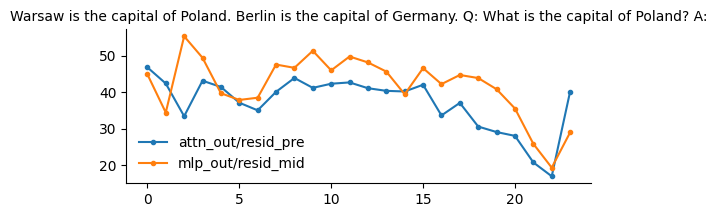

In [212]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from measureLM import helpers

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


fig, ax = plt.subplots(1, 1, figsize=(6, 2), gridspec_kw={'hspace': 0.4})

mods = list(mod_layer_dist.keys())
layers = np.array(list(range(0,model.cfg.n_layers)))

for mod in mods:
    lines = ax.plot(layers, mod_layer_dist[mod], marker=".", label=mod)

ax.set_title(prompts[example][i], fontsize=10, color="black", loc='center')
ax.legend(frameon=False)


{k: v.sum() for k,v in mod_layer_dist.items()}

In [213]:
activs[""]

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re